In [1]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Агрегация профилей пользователя - источника перехода, первое посещение, регистрация, первый платёж

### Типичный набор данных пользователя

Все системы бизнес-аналитики собирают примерно один и тот же минимальный набор информации о пользователях. Есть две большие группы данных: журнал посещений сайта пользователями, то есть пользовательских сессий, и журнал покупок.

#### Данные журнала пользовательских сессий

- `user_id` - уникальный идентификатор пользователя;
- `session_start` - дата начала сессии;
- `session_duration` или `session_end` - дата окончания или длительность сессии;
- `device` — устройство, с которого пользователь заходил на сайт;
- `region` — географическое положение в момент посещения сайта;
- `channel` —  рекламный канал, источник переходов или иной ресурс, с которого пользователь перешёл на сайт.

#### Данные журнала покупок

- уникальный идентификатор пользователя,
- дата совершения покупки,
- сумма покупки.

### Создание профилей пользователей

1. Загрузить данные журнала посещений.
2. Для каждого пользователя определить дату и время первой сессии.
3. Для каждого пользователя определить соответствующие задаче параметры первой сессии. Например, источник перехода на сайт.

In [2]:
# загружаем журнал сессий
sessions = pd.read_csv('https://code.s3.yandex.net/datasets/sessions.csv')

# преобразуем данные о времени для дальнейших расчётов
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

sessions

,user_id,region,device,channel,session_duration,session_start
0,94834909438,Germany,iPhone,Yandex,5.417238,2019-05-01 12:59:48
1,142292250445,United States,iPhone,Organic,33.232475,2019-05-01 21:25:00
2,486879489291,United States,Mac,Organic,33.635569,2019-05-01 21:18:40
3,996478278264,Germany,iPhone,Yandex,76.792801,2019-05-01 07:37:52
4,857023407503,United States,Android,Organic,5.976421,2019-05-01 01:35:01
...,...,...,...,...,...,...
282932,507281681954,United States,PC,Organic,6.316422,2019-05-14 06:35:22
282933,584727896171,France,PC,Organic,51.814506,2019-05-14 18:23:01
282934,200769562990,United States,Android,Organic,15.380831,2019-05-14 16:20:10
282935,569449250064,Germany,iPhone,Organic,24.139972,2019-05-14 09:15:01


#### `get_profiles()`:

- `sessions` — данные журнала сессий.

Для создания пользовательских профилей с датой первого посещения и источником перехода на сайт напишем функцию `get_profiles()`. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию `first()`:

In [3]:
def get_profiles(sessions):
    profiles = (
        # сортируем сессии по ID пользователя и дате посещения
        sessions.sort_values(by=['user_id', 'session_start'])
        # группируем по ID и находим первые значения session_start и channel
        .groupby('user_id')
        .agg({
            'session_start': 'first',
            'channel': 'first',
            'device': 'first',
            'region': 'first'
        })
        # столбец с временем первого посещения назовём first_ts
        # от англ. first timestamp — первая временная отметка
        .rename(columns={
            'session_start': 'first_session_start',
            'channel': 'first_channel',
            'device': 'first_device',
            'region': 'first_region'
        })
        # возвращаем user_id из индекса
        .reset_index()
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['cohort_by_date'] = profiles['first_session_start'].dt.date
    profiles['cohort_by_month'] = profiles['first_session_start'].astype('datetime64[M]')

    return profiles

In [4]:
# создаём профили пользователей, используя записи об их посещениях
profiles = get_profiles(sessions)

profiles

,user_id,first_session_start,first_channel,first_device,first_region,cohort_by_date,cohort_by_month
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01
...,...,...,...,...,...,...,...
141414,999939571625,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01
141415,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01
141416,999957797889,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01
141417,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01


Имея готовые профили пользователей, легко узнать количество привлечённых каждым источником посетителей. Достаточно сгруппировать профили по рекламному каналу и посчитать количество уникальных ID функцией `nunique()`:

In [5]:
profiles.groupby('first_channel').agg({'user_id': 'nunique'})

,user_id
first_channel,
AnotherSource,24751
Organic,69288
Yandex,47380


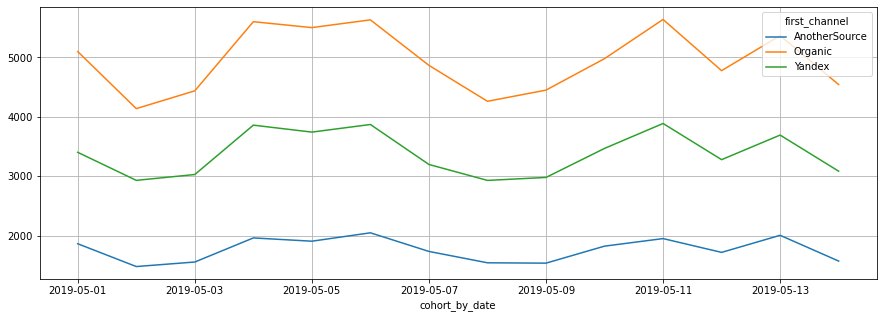

In [6]:
profiles.pivot_table(
    index='cohort_by_date',  # даты первых посещений
    columns='first_channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

## Retention Rate

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией.

Чтобы узнать Retention Rate, нужно разделить количество активных пользователей когорты в нужный день на количество активных пользователей когорты на первый день.

Шаги:

- Собрать таблицу событий:
  - Объединить данные сессий с профилями.
  - Рассчитать лайфтайм пользователя для каждой сессии.
- Построить таблицу долей удержания:
   - Построить таблицу удержания. То есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — количество уникальных идентификаторов пользователей.
   - Вычислить размеры когорт и занести результаты в отдельную таблицу.
   - Разделить каждую «ячейку» таблицы удержания на соответствующий размер когорты.

In [7]:
# в данном случае событие - это заход на сайт, сессия
# собираем данные о событиях: к данным о сессиях добавляем данные о профиле пользователя
events = sessions.merge(profiles, on='user_id', how='right')

# вычисляем лайфтайм каждого события в днях
events['lifetime'] = (
    events['session_start'] - events['first_session_start']
).dt.days

events

,user_id,region,device,channel,session_duration,session_start,first_session_start,first_channel,first_device,first_region,cohort_by_date,cohort_by_month,lifetime
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,0
1,10964006,Germany,Mac,Yandex,9.317945,2019-05-13 04:00:27,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,0
2,10964006,Germany,Mac,Yandex,21.288979,2019-05-14 04:21:06,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,1
3,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,0
4,12358165,United States,iPhone,Yandex,0.953297,2019-05-11 11:01:14,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282932,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01,0
282933,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01,0
282934,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01,0
282935,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05 09:27:58,AnotherSource,iPhone,Russian Federation,2019-05-05,2019-05-01,0


In [8]:
# строим таблицу удержания - сколько пользователей из когорты повторили действие в каждый лайфтайм
retention = events.pivot_table(
    index=['cohort_by_date'], columns='lifetime', values='user_id', aggfunc='nunique'
)

retention

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_by_date,,,,,,,,,,,,,,
2019-05-01,10369.0,4213.0,3059.0,2415.0,1993.0,1750.0,1473.0,1418.0,1250.0,1107.0,1013.0,917.0,869.0,404.0
2019-05-02,8556.0,3410.0,2575.0,1986.0,1730.0,1430.0,1207.0,1084.0,992.0,862.0,857.0,803.0,402.0,NaN
2019-05-03,9029.0,1715.0,924.0,551.0,369.0,285.0,238.0,185.0,144.0,123.0,118.0,35.0,NaN,NaN
2019-05-04,11426.0,2143.0,1200.0,694.0,470.0,339.0,275.0,233.0,199.0,160.0,65.0,NaN,NaN,NaN
2019-05-05,11155.0,1502.0,622.0,378.0,222.0,145.0,129.0,76.0,64.0,37.0,NaN,NaN,NaN,NaN
2019-05-06,11554.0,2839.0,1584.0,1114.0,796.0,661.0,503.0,407.0,187.0,NaN,NaN,NaN,NaN,NaN
2019-05-07,9804.0,2343.0,1429.0,935.0,707.0,529.0,404.0,208.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08,8741.0,2558.0,1654.0,1160.0,909.0,690.0,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,8973.0,3253.0,2406.0,1781.0,1473.0,675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# вычисляем размеры когорт
cohort_sizes = (
    # Сгруппируем данные по дате первого посещения из `dt`
    events.groupby('cohort_by_date')
    # и посчитаем количество уникальных пользователей в каждой когорте,
    # применив функцию `nunique` к столбцу `user_id`.
    .agg({'user_id': 'nunique'})
    # теперь это серия, которая содержит размер когорты
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
cohort_by_date,
2019-05-01,10369
2019-05-02,8556
2019-05-03,9029
2019-05-04,11426
2019-05-05,11155
2019-05-06,11554
2019-05-07,9804
2019-05-08,8741
2019-05-09,8973


In [10]:
# делим данные таблицы удержания на размеры когорт
retention_rates = retention.div(
    cohort_sizes['cohort_size'], axis=0
)

retention_rates

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_by_date,,,,,,,,,,,,,,
2019-05-01,1.0,0.406307,0.295014,0.232906,0.192208,0.168772,0.142058,0.136754,0.120552,0.106761,0.097695,0.088437,0.083808,0.038962
2019-05-02,1.0,0.398551,0.300958,0.232118,0.202197,0.167134,0.141071,0.126695,0.115942,0.100748,0.100164,0.093852,0.046985,NaN
2019-05-03,1.0,0.189944,0.102337,0.061026,0.040868,0.031565,0.026360,0.020490,0.015949,0.013623,0.013069,0.003876,NaN,NaN
2019-05-04,1.0,0.187555,0.105024,0.060739,0.041134,0.029669,0.024068,0.020392,0.017416,0.014003,0.005689,NaN,NaN,NaN
2019-05-05,1.0,0.134648,0.055760,0.033886,0.019901,0.012999,0.011564,0.006813,0.005737,0.003317,NaN,NaN,NaN,NaN
2019-05-06,1.0,0.245716,0.137095,0.096417,0.068894,0.057210,0.043535,0.035226,0.016185,NaN,NaN,NaN,NaN,NaN
2019-05-07,1.0,0.238984,0.145757,0.095369,0.072113,0.053958,0.041208,0.021216,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08,1.0,0.292644,0.189223,0.132708,0.103993,0.078938,0.035694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,1.0,0.362532,0.268138,0.198484,0.164159,0.075226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### `get_lifetime()`

- `events` - список действий
- `profiles` - список 

In [11]:
def get_attributed_events(events, profiles):
    # в данном случае событие - это заход на сайт, сессия
    # собираем данные о событиях: к данным о сессиях добавляем данные о профиле пользователя
    events = events.merge(profiles, on='user_id', how='right')

    # вычисляем лайфтайм каждого события в днях
    events['lifetime'] = (
        events['session_start'] - events['first_session_start']
    ).dt.days
    
    return events

In [12]:
attributed_events = get_attributed_events(
    sessions,
    get_profiles(sessions),
)

attributed_events

,user_id,region,device,channel,session_duration,session_start,first_session_start,first_channel,first_device,first_region,cohort_by_date,cohort_by_month,lifetime
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,0
1,10964006,Germany,Mac,Yandex,9.317945,2019-05-13 04:00:27,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,0
2,10964006,Germany,Mac,Yandex,21.288979,2019-05-14 04:21:06,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,1
3,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,0
4,12358165,United States,iPhone,Yandex,0.953297,2019-05-11 11:01:14,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282932,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01,0
282933,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01,0
282934,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01,0
282935,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05 09:27:58,AnotherSource,iPhone,Russian Federation,2019-05-05,2019-05-01,0


### `get_retention_rates()`

- `events` - список действий,
- `dimensions` - список признаков, по которым разделяем на когорты.

In [13]:
def get_retention_rates(events, dimensions=[]):    
    # строим таблицу удержания - сколько пользователей из когорты повторили действие в каждый лайфтайм
    retention = events.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )

    # делим данные таблицы удержания на размеры когорт
    # а размеры когорт тут в лайфтайме 0!
    retention_rates = retention.div(
        retention[0], axis=0
    )
    
    # выкидываем лайфтайм 0 - он бесполезен
    # в нём по определению удержание всегда 100%
    return retention_rates.drop(columns=[0])

In [14]:
retention_rates = get_retention_rates(attributed_events, dimensions=['cohort_by_date'])

retention_rates

lifetime,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_by_date,,,,,,,,,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772,0.142058,0.136754,0.120552,0.106761,0.097695,0.088437,0.083808,0.038962
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134,0.141071,0.126695,0.115942,0.100748,0.100164,0.093852,0.046985,NaN
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565,0.026360,0.020490,0.015949,0.013623,0.013069,0.003876,NaN,NaN
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669,0.024068,0.020392,0.017416,0.014003,0.005689,NaN,NaN,NaN
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999,0.011564,0.006813,0.005737,0.003317,NaN,NaN,NaN,NaN
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210,0.043535,0.035226,0.016185,NaN,NaN,NaN,NaN,NaN
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958,0.041208,0.021216,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938,0.035694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,0.362532,0.268138,0.198484,0.164159,0.075226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Учёт момента и горизонта анализа

**Момент анализа данных** - это момент времени, который нужно отобразить в резульаттах анализа. Что в этот момент происходило? Как всё выглядело?

**Горизонт анализа данных** - максимальный лайфтайм, который мы включаем в анализ.

- Задать момент и горизонт анализа.
- Определить, игнорировать ли горизонт.
- Рассчитать максимально возможную дату привлечения пользователей.
- Исключить из анализа пользователей, пришедших после этой даты.
- Исключить из результата все лайфтаймы, превышающие горизонт анализа.

In [15]:
horizon = 6
observation_date = datetime.datetime(2019, 5, 13).date()

# преобразуем данные о времени для дальнейших расчётов
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

if profiles is None:
    # создаём профили пользователей, используя записи об их посещениях
    profiles = get_profiles(sessions)

if not observation_date:
    observation_date = sessions['session_start'].dt.date.max()

# Последний приемлимый период - это дата наблюдения.
# Исходя из того, что за эту дату есть полные данные,
# это не должна быть сегодняшняя дата -
# данные за сегодня не полны, день не кончился.
# По умолчанию, последний приемлемый период - "день наблюдения".
last_suitable_acquisition_date = observation_date
# Но если задан горизонт наблюдений,
if horizon:
    # то последний приемлемый период - тот, который настал на
    # {horizon} периодов перед {observation_date}.
    last_suitable_acquisition_date -= datetime.timedelta(days=horizon - 1)

# исключаем профили, которые слишком молоды,
# чтобы прожить нужное количество периодов
# "у них максимальный лайфтайм меньше чем горизонт анализа"
suitable_profiles = profiles.query('cohort_by_date <= @last_suitable_acquisition_date')

# дополняем данные только теми, которые в нужных профилях
attributed_events = get_attributed_events(sessions, suitable_profiles)

# по умолчанию считаем, что любые лайфтаймы нас устроят
suitable_events = attributed_events
# но если указан горизонт анализа - то...
if horizon:
    # оставляем только записи с лайфтаймами,
    # которые меньше чем горизонт анализа
    suitable_events = attributed_events.query('lifetime < @horizon')

get_retention_rates(suitable_events, dimensions=['cohort_by_date'])

lifetime,1,2,3,4,5
cohort_by_date,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938


### `get_retention()`

- `events` — данные журнала событий (сессий/посещений, регистраций, установок, покупок...),
- `profiles` — профили пользователей (по умолчанию не заданы),
- `dimensions` - список признаков, по которым разделяем на когорты,
- `observation_date` — момент анализа (по умолчанию не задан),
- `horizon` — горизонт анализа в днях (по умолчанию не задан).

In [16]:
def get_retention(events, profiles=None, dimensions=[], observation_date=None, horizon=None):
    if profiles is None:
        # создаём профили пользователей, используя записи об их посещениях
        profiles = get_profiles(sessions)

    if not observation_date:
        observation_date = sessions['session_start'].dt.date.max()

    # Последний приемлимый период - это дата наблюдения.
    # Исходя из того, что за эту дату есть полные данные,
    # это не должна быть сегодняшняя дата -
    # данные за сегодня не полны, день не кончился.
    # По умолчанию, последний приемлемый период - "день наблюдения".
    last_suitable_acquisition_date = observation_date
    # Но если задан горизонт наблюдений,
    if horizon:
        # то последний приемлемый период - тот, который настал на
        # {horizon} периодов перед {observation_date}.
        last_suitable_acquisition_date -= datetime.timedelta(days=horizon - 1)

    # исключаем профили, которые слишком молоды,
    # чтобы прожить нужное количество периодов
    # "у них максимальный лайфтайм меньше чем горизонт анализа"
    suitable_profiles = profiles.query('cohort_by_date <= @last_suitable_acquisition_date')

    # дополняем данные только теми, которые в нужных профилях
    attributed_events = get_attributed_events(sessions, suitable_profiles)

    # по умолчанию считаем, что любые лайфтаймы нас устроят
    suitable_events = attributed_events
    # но если указан горизонт анализа - то...
    if horizon:
        # оставляем только записи с лайфтаймами,
        # которые меньше чем горизонт анализа
        suitable_events = attributed_events.query('lifetime < @horizon')
    
    retention = get_retention_rates(suitable_events, dimensions)

    return suitable_events, retention

In [17]:
events, retention = get_retention(
    events=sessions,
    dimensions=['cohort_by_date'],
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
)

In [18]:
retention

lifetime,1,2,3,4,5
cohort_by_date,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938


In [19]:
events

,user_id,region,device,channel,session_duration,session_start,first_session_start,first_channel,first_device,first_region,cohort_by_date,cohort_by_month,lifetime
0,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,0
1,12545358,United States,Mac,Organic,16.607699,2019-05-06 03:18:30,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,0
2,47343201,United States,iPhone,Organic,14.140214,2019-05-07 16:55:48,2019-05-07 16:55:48,Organic,iPhone,United States,2019-05-07,2019-05-01,0
3,51602715,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,2019-05-03 14:57:36,Organic,iPhone,Russian Federation,2019-05-03,2019-05-01,0
4,51602715,Russian Federation,iPhone,Organic,1.793384,2019-05-04 19:08:27,2019-05-03 14:57:36,Organic,iPhone,Russian Federation,2019-05-03,2019-05-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171773,999939571625,Germany,iPhone,Yandex,35.694236,2019-05-10 23:13:21,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01,2
171774,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01,0
171775,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01,0
171776,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05 09:27:58,AnotherSource,iPhone,Russian Federation,2019-05-05,2019-05-01,0


### Визуализация

#### Тепловая карта удержания

Хитмэп — отличный выбор, если вы хотите сравнить удержание нескольких когорт.

In [20]:
_, triangle_retention = get_retention(sessions, dimensions=['cohort_by_date'])

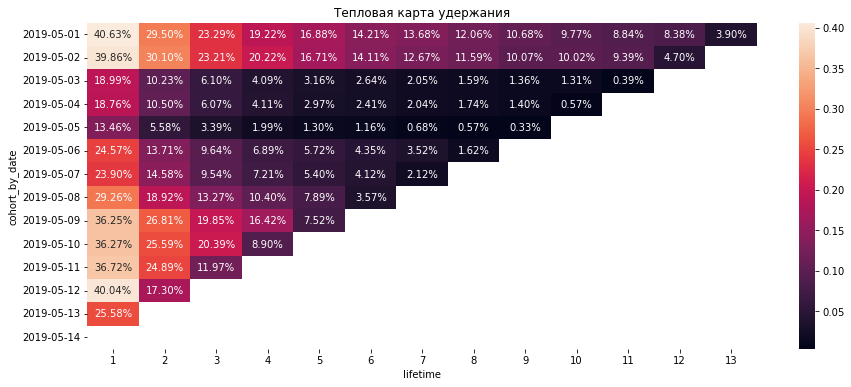

In [21]:
# строим хитмэп
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    triangle_retention,
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

#### Кривая удержания

Кривые удержания подходят для «быстрого» сравнения показателей. Метод `plot()` строит график, на котором линии отражают значения каждого столбца датафрейма.

In [22]:
retention

lifetime,1,2,3,4,5
cohort_by_date,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938


In [23]:
# транспонирование (переворачивание) таблицы с помощью атрибута T:
# столбцы становятся строками, а строки - столбцами
test = retention.T

test

cohort_by_date,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08
lifetime,,,,,,,,
1,0.406307,0.398551,0.189944,0.187555,0.134648,0.245716,0.238984,0.292644
2,0.295014,0.300958,0.102337,0.105024,0.055760,0.137095,0.145757,0.189223
3,0.232906,0.232118,0.061026,0.060739,0.033886,0.096417,0.095369,0.132708
4,0.192208,0.202197,0.040868,0.041134,0.019901,0.068894,0.072113,0.103993
5,0.168772,0.167134,0.031565,0.029669,0.012999,0.057210,0.053958,0.078938


In [24]:
# это способ получить названия строк
test.index.values

array([1, 2, 3, 4, 5], dtype=int64)

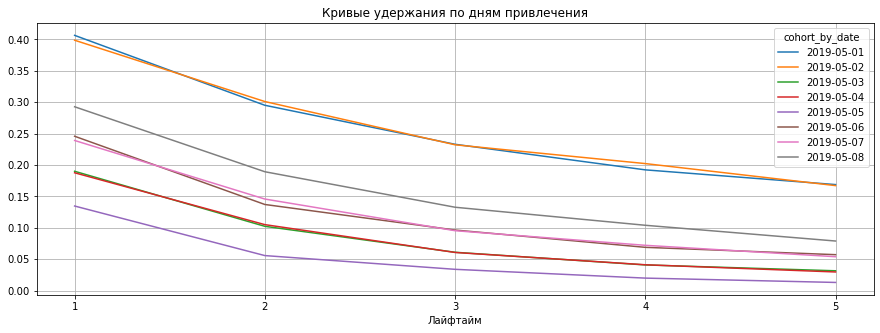

In [25]:
# строим кривые удержания
retention.T.plot(
    grid=True,
    # отметки на оси X — названия колонок retention, то есть - номера лайфтаймов
    xticks=list(retention.columns.values),
    figsize=(15, 5),
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

#### Кривые истории изменения удержаний

Если задача — проанализировать, как менялось удержание от когорты к когорте для каждого дня «жизни» пользователей, подойдёт график истории изменений.

Построить такой график проще всего — достаточно вызвать `plot()` к таблице удержания. Без всякого транспонирования.

Каждая линия на этом графике показывает, как менялось удержание пользователей на определённый лайфтайм. Например, синяя линия сверху отражает изменения в удержании второго дня или первого лайфтайма (лайфтайм 1 - прошёл один полный день, идёт второй), а нижняя фиолетовая — в удержании шестого дня.

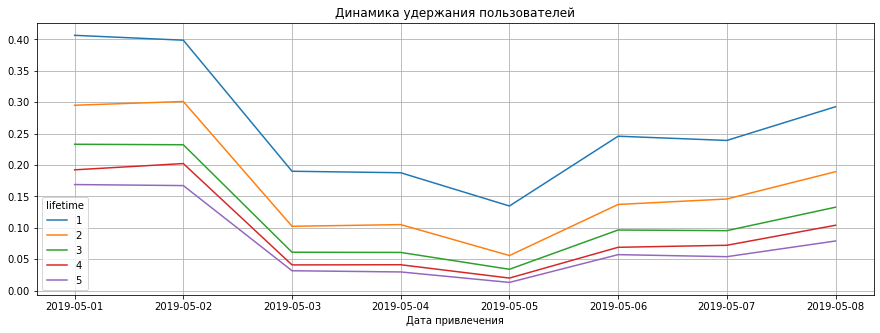

In [26]:
# строим графики изменений
retention.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

In [27]:
profiles = pd.read_csv('https://code.s3.yandex.net/datasets/profiles_backup.csv')
profiles['first_session_start'] = pd.to_datetime(profiles['first_ts'])
profiles['cohort_by_date'] = pd.to_datetime(profiles['dt']).dt.date

profiles

,user_id,first_ts,channel,device,region,dt,month,payer,first_session_start,cohort_by_date
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-12 04:50:17,2019-05-12
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-10 23:16:24,2019-05-10
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False,2019-05-05 19:22:46,2019-05-05
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-10 20:29:59,2019-05-10
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01 00:00:00,True,2019-05-12 11:08:25,2019-05-12
...,...,...,...,...,...,...,...,...,...,...
141414,999939571625,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01 00:00:00,False,2019-05-08 17:47:00,2019-05-08
141415,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01 00:00:00,False,2019-05-04 09:57:28,2019-05-04
141416,999957797889,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01 00:00:00,False,2019-05-14 21:54:26,2019-05-14
141417,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01 00:00:00,False,2019-05-07 03:42:53,2019-05-07


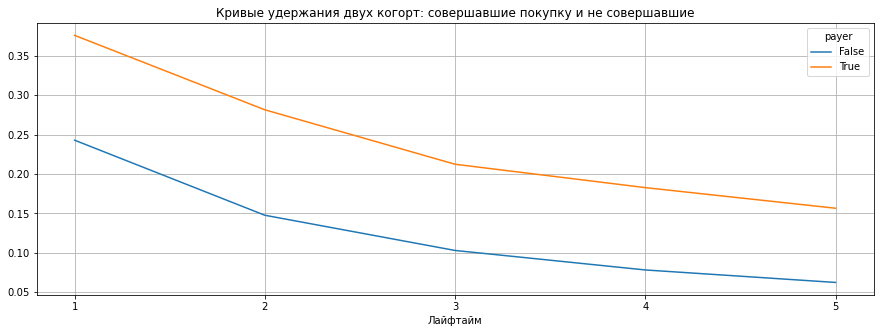

In [28]:
#events = get_attributed_events(sessions, profiles=profiles)
#display(events)

events, retention = get_retention(
    sessions,
    profiles=profiles,
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
    dimensions=['payer'],
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
retention.T.plot(grid=True, xticks=retention.columns.values, figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания двух когорт: совершавшие покупку и не совершавшие')
plt.show()

### Графики, которые отображают когорты с двумя-тремя признаками

Удержание платящих значительно выше удержания неплатящих. Так бывает почти всегда, поэтому разбивка пользователей на платящих и неплатящих — стандартная практика. Сделаем `get_retention` с разбивкой на когорты: плательщики и лиды.

#### `get_retention_rates()` featuring `payer` cohort dimension if `attributed_events` contains `payer`

In [29]:
def get_retention_rates(events, dimensions=[]):
    # сразу ищем, есть ли возможность разделить пользователей
    # на когорты "плательщик" и "лид"
    if 'payer' in events.columns:
        dimensions = ['payer'] + dimensions
    
    # строим таблицу удержания - сколько пользователей из когорты повторили действие в каждый лайфтайм
    retention = events.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )

    # делим данные таблицы удержания на размеры когорт
    # а размеры когорт тут в лайфтайме 0!
    retention_rates = retention.div(
        retention[0], axis=0
    )
    
    # выкидываем лайфтайм 0 - он бесполезен
    # в нём по определению удержание всегда 100%
    return retention_rates.drop(columns=[0])

In [30]:
events, retention = get_retention(
    sessions,
    # а следующий фрейм содержит колонку `payer`
    # если колонку или весь фрейм убрать - то разбивка
    # на тех кто платил и кто не платил - исчезнет
    profiles=profiles,
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
    dimensions=['cohort_by_date']
)

retention

lifetime                     1         2         3         4         5
payer cohort_by_date                                                  
False 2019-05-01      0.393571  0.277360  0.219415  0.178349  0.153085
      2019-05-02      0.383736  0.286259  0.217288  0.190489  0.149501
      2019-05-03      0.174613  0.086192  0.049288  0.031827  0.025759
      2019-05-04      0.170638  0.088482  0.050124  0.030746  0.023529
      2019-05-05      0.121505  0.045564  0.026152  0.014283  0.008348
      2019-05-06      0.230010  0.122943  0.084898  0.056922  0.046467
      2019-05-07      0.226306  0.132662  0.084822  0.059036  0.044786
      2019-05-08      0.280239  0.177107  0.118156  0.089509  0.066463
True  2019-05-01      0.517338  0.448922  0.350515  0.313027  0.305530
      2019-05-02      0.518008  0.419492  0.351695  0.296610  0.309322
      2019-05-03      0.319706  0.238994  0.160377  0.117400  0.080713
      2019-05-04      0.318078  0.232647  0.142639  0.121281  0.077040
      2019-05-05      0.242374  0.139324  0.097279  0.065952  0.051113
      2019-05-06      0.378268  0.256536  0.193627  0.169935  0.147876
      2019-05-07      0.355509  0.266112  0.192308  0.192308  0.138254
      2019-05-08      0.402480  0.296505  0.261556  0.232244  0.189402

#### Графики удержания - тепловые карты

Видим, что у нас составной индекс.

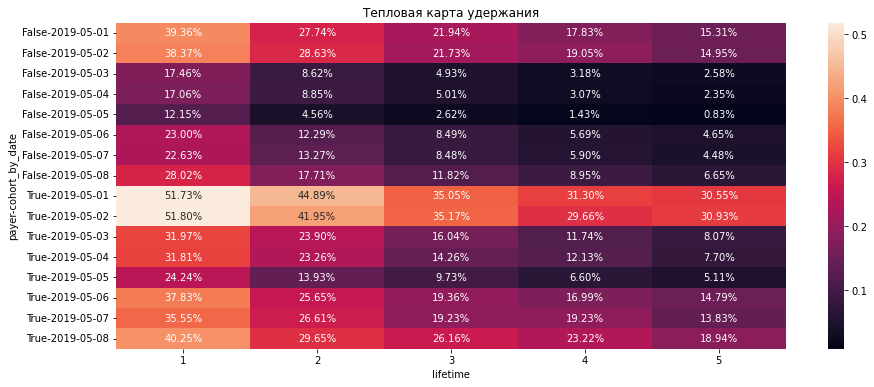

In [31]:
plt.figure(figsize=(15, 6))
sns.heatmap(retention, annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

Теперь каждой строке таблицы удержания соответствуют два параметра: дата и признак совершения покупки. График и подписи заметно разрослись.

Разделим график надвое: построим по тепловой карте для каждой группы пользователей — платящих и неплатящих. Для этого вызовем функцию `figure()` из модуля `pyplot` библиотеки `matplotlib` и напишем цикл `for`.

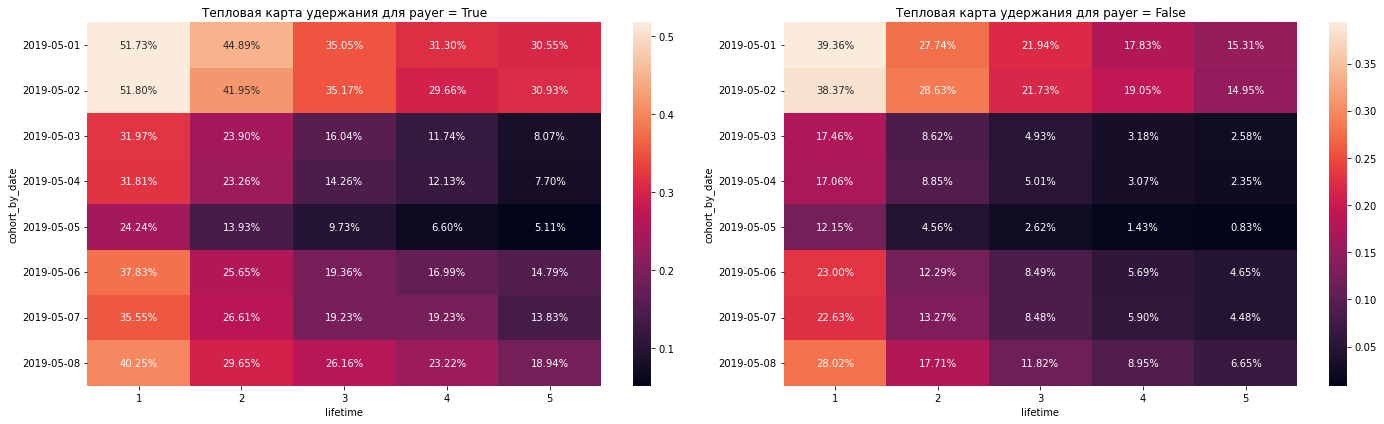

In [32]:
plt.figure(figsize=(20, 6)) # задаём размер холста для графиков

# берём порядковый номер и имя категории
# а категорий всего две: "платил" и "не платил"
for i, payer in enumerate(profiles['payer'].unique()):
    sns.heatmap(
        # из всей таблицы удержаний берём только те записи,
        # где индекс 'payer' равен значению 'payer' из итератора
        retention.query('payer == @payer')
        # удаляем индекс payer - он теперь не нужен
        .droplevel('payer'),
        # добавляем подписи значений
        annot=True,
        # переводим значения в проценты
        fmt='.2%',
        # строим каждый график в своей ячейке
        # (number_of_rows, number_of_cols, index)
        # index starts at 1 in the upper left corner and increases to the right.
        # index can also be a two-tuple specifying the (first, last) indices
        # (1-based, and including last) of the subplot,
        # e.g., fig.add_subplot(3, 1, (1, 2)) makes a subplot
        # that spans the upper 2/3 of the figure.
        ax=plt.subplot(1, 2, i + 1),
    )
    # задаём названия графиков с учётом значения payer
    plt.title('Тепловая карта удержания для payer = {}'.format(payer))

plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
plt.show()

В программе для построения двух хитмэпов мы передали функции `subplot()` аргументы `1`, `2` и `i + 1`: в таблице графиков одна строка и два столбца. 

```python
        ax=plt.subplot(1, 2, i + 1)
```

Переменная `i` принимает значения `0` и `1`, а нумерация ячеек в таблице графиков начинается с единицы, поэтому значение `i` увеличиваем на один. Так первый график окажется в первой ячейке, а второй — во второй.

#### Графики удержания - линейные диаграммы

Проанализируем удержание с разбивкой когорт не по дате, а по другому параметру — устройству, с которого пользователи впервые зашли на сайт. Эта информация сохранена в столбце `device` — добавим его в параметр `dimensions`. Горизонт и момент анализа данных остаются прежними. Вызовем функцию `get_retention()` и построим хитмэп.

In [33]:
_, retention = get_retention(
    sessions,
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device_y'],
)

retention

lifetime               1         2         3         4         5
payer device_y                                                  
False Android   0.249548  0.146056  0.103978  0.078453  0.060926
      Mac       0.237832  0.149053  0.101431  0.077178  0.063532
      PC        0.236694  0.144959  0.100695  0.081573  0.064857
      iPhone    0.244154  0.148062  0.103721  0.077752  0.061591
True  Android   0.368545  0.281103  0.220657  0.167840  0.153169
      Mac       0.392429  0.289411  0.229995  0.184954  0.143268
      PC        0.378468  0.275250  0.211987  0.185350  0.150943
      iPhone    0.369767  0.278811  0.199225  0.187339  0.166408

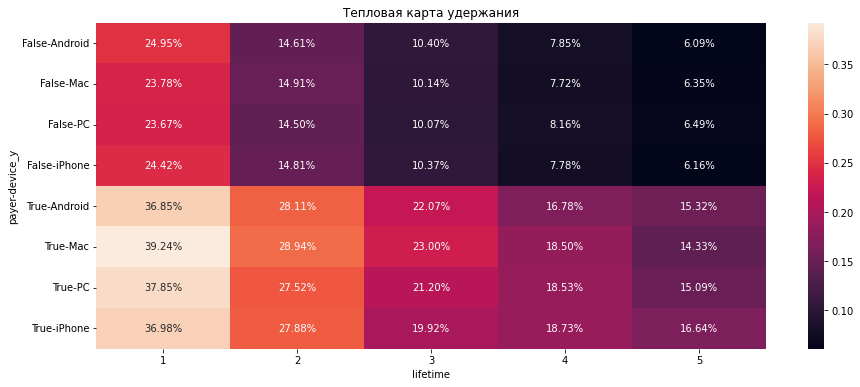

In [34]:
plt.figure(figsize=(15, 6))
sns.heatmap(retention, annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

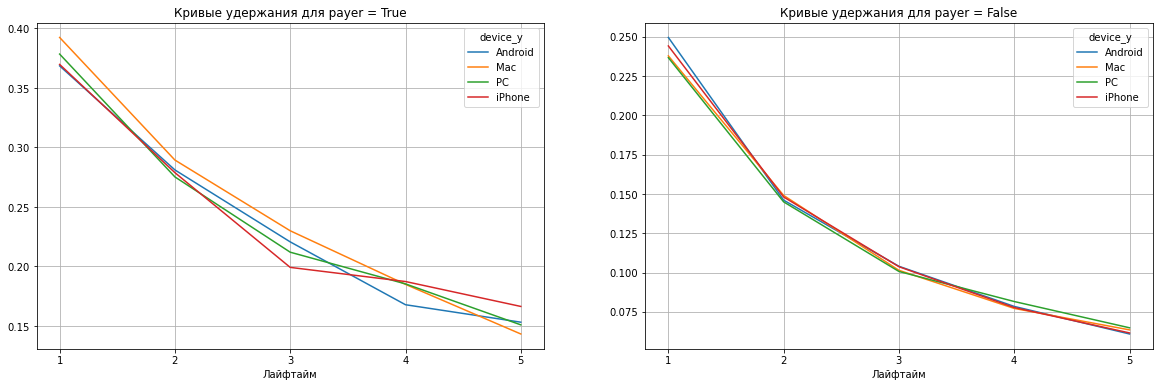

In [35]:
plt.figure(figsize=(20, 6))
for i, payer in enumerate(profiles['payer'].unique()):
    retention.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=retention.columns.values,
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

По правому графику с кривыми удержания неплатящих пользователей сложно определить, пользователи каких устройств удерживаются хоть сколько-то лучше.

#### Графики истории изменений

Избежать слияния линий позволит третий изученный вами способ визуализации — график истории изменений. На таком графике каждая линия соответствует определённому лайфтайму, а по горизонтальной оси отмечены даты привлечения пользователей. 

Однако построить его теперь непросто: после добавления параметра `dimensions` даты привлечения пользователей пропали из таблицы удержания.

История изменений удержания - это по сути анализ когорт, у которых главный признак - период, в который когорта пришла. Даты становятся обязательным признаком.

In [36]:
_, retention = get_retention(
    sessions,
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device_y', 'cohort_by_date'],
)

retention

lifetime                              1         2         3         4  \
payer device_y cohort_by_date                                           
False Android  2019-05-01      0.392990  0.278279  0.217207  0.169411   
               2019-05-02      0.404856  0.288058  0.220472  0.188976   
               2019-05-03      0.183611  0.089341  0.051756  0.034504   
               2019-05-04      0.168753  0.089134  0.048573  0.033050   
               2019-05-05      0.133827  0.044938  0.029136  0.015309   
...                                 ...       ...       ...       ...   
True  iPhone   2019-05-04      0.319444  0.241319  0.126736  0.123264   
               2019-05-05      0.251773  0.127660  0.086879  0.070922   
               2019-05-06      0.361582  0.256121  0.169492  0.167608   
               2019-05-07      0.328671  0.289044  0.156177  0.193473   
               2019-05-08      0.394937  0.311392  0.250633  0.232911   

lifetime                              5  
payer device_y cohort_by_date            
False Android  2019-05-01      0.152416  
               2019-05-02      0.147638  
               2019-05-03      0.024646  
               2019-05-04      0.020531  
               2019-05-05      0.007901  
...                                 ...  
True  iPhone   2019-05-04      0.085069  
               2019-05-05      0.051418  
               2019-05-06      0.148776  
               2019-05-07      0.153846  
               2019-05-08      0.207595  

[64 rows x 5 columns]

Получаем таблицу удержания, сгруппированную по трём признакам:

- Совершение покупок. Столбец `payer`, значение `True` или `False`.
- Устройство, с которого пользователь просматривает сайт. Столбец `device`, значения `Android`, `Mac`, `PC` или `iPhone`.
- Дата привлечения пользователей. Столбец `dt` с датами от 1 до 8 мая 2019 года.

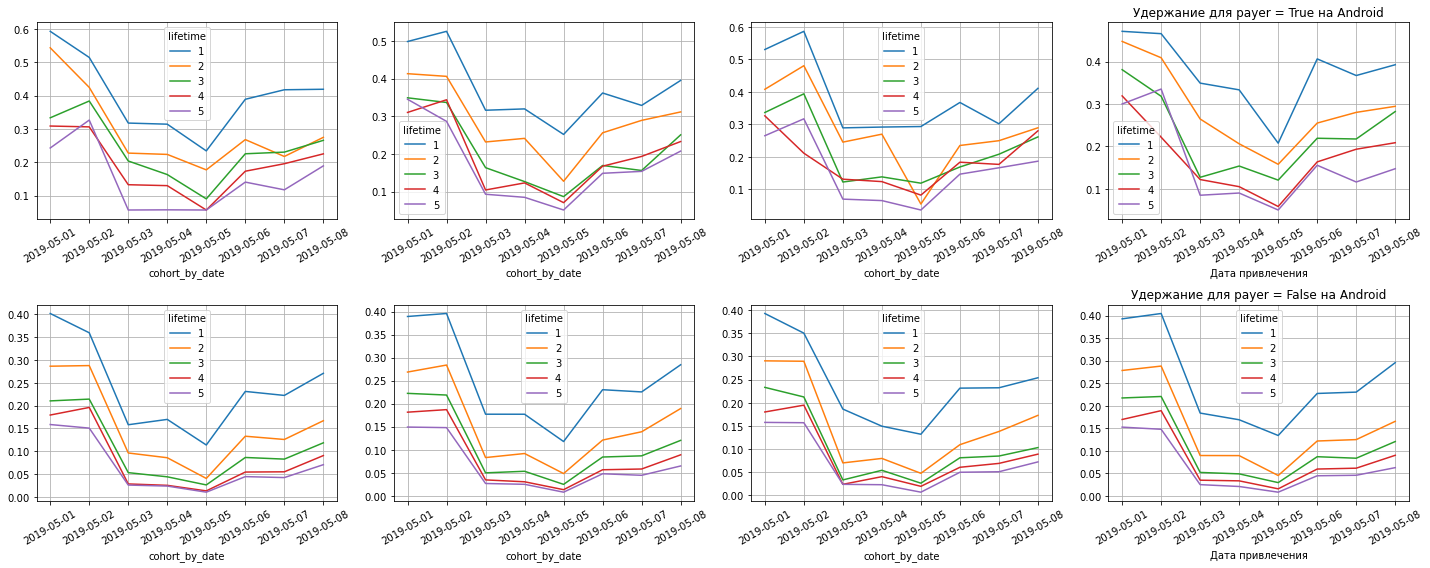

In [37]:
# холст для графиков будет такого размера
plt.figure(figsize=(20, 8))

# на холст графики станут в столько рядов,
# сколько вариантов в 'payer'
nrows = len(profiles['payer'].unique())
# и столько столбцов, сколько вариантов в 'payer'
ncols = len(profiles['device'].unique())

# наружний цикл - перебор строк, рядов
for i, payer in enumerate(profiles['payer'].unique()):
    # внутренний цикл - перебо столбцов, позиций в ряду
    for j, device in enumerate(profiles['device'].unique()):
        (
            # оставляем записи, в которых нужный статус плательщика и нужное устройство
            retention.query('payer == @payer and device_y == @device')
            .droplevel(['payer', 'device_y'])
            .plot(
                grid=True,
                # количество рядов и ячеек в ряду - берутся из констант, заданных до цикла
                # номер ячейки, куда запишем диаграмму - вычисляется
                # на основе порядковых номеров итераций циклов
                ax=plt.subplot(nrows, ncols, i * ncols + j + 1),
                rot=30,
            )
        )
    plt.xlabel('Дата привлечения')
    plt.title('Удержание для payer = {} на {}'.format(payer, device))

# Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

#### Линейные графики удержания

В принципе, это же можно увидеть и на обычных линейных графиках удержания. Построим их, запустив код, который мы использовали для одного дополнительного признака, но теперь  - с двумя дополнительными.

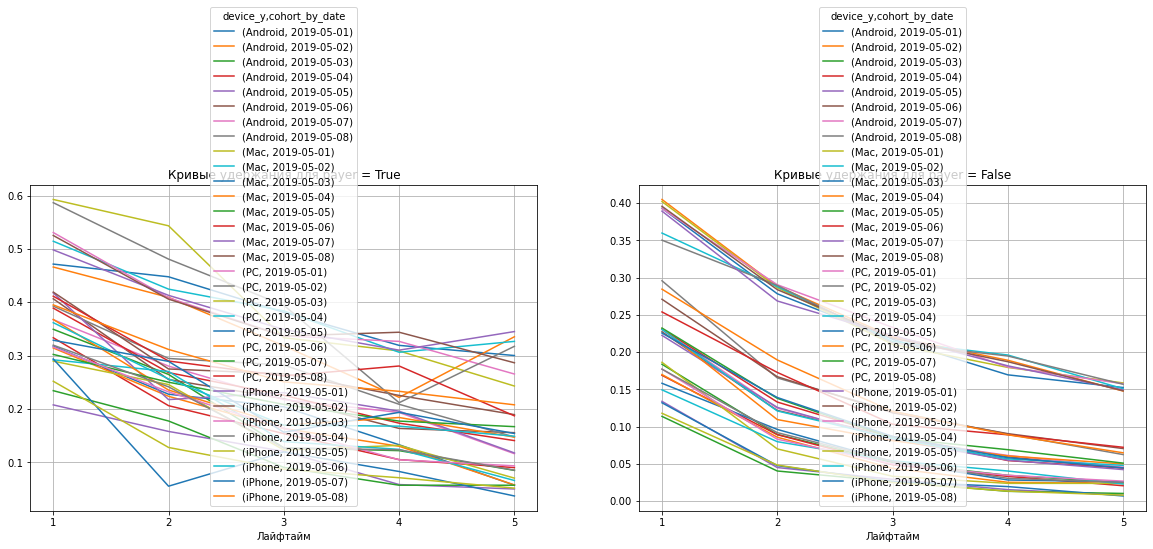

In [38]:
plt.figure(figsize=(20, 6))  # задаём размер сетки

for i, payer in enumerate(profiles['payer'].unique()):
    retention.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=retention.columns.values,
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Итак, каждая линия - когорта по трём признакам. Один признак - платежи, по ним когорты распределены вправо и влево. В целом, было бы удобнее распределить их так, как в примере с историей удержания - по горизонтали устройста, по вертикали - наличие платежей.

#### График удержания по платежам и устройствам


Чтобы построить кривые удержания с разбивкой по совершению покупок и устройствам, параметру `dimensions` при вызове функции `get_retention()` нужно передать только столбец `device`. Перегруппировать текущую таблицу уже не выйдет: для группировки нужны сырые данные, а не готовые коэффициенты.

На практике аналитик почти всегда хочет видеть и кривые удержания, и графики истории изменений. Чтобы иметь доступ и к тому, и к другому виду графиков, можно вызвать `get_retention()` дважды — с разным набором столбцов в параметре `dimensions`.


In [39]:
# один вызов для построения кривых удержания
events, retention = get_retention(
    sessions,
    profiles=profiles,
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
    dimensions=['device_y'], 
)

# и другой — для построения графиков динамики удержания
events, retention_history = get_retention(
    sessions,
    profiles=profiles,
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
    dimensions=['device_y', 'cohort_by_date'], 
)

Однако это не лучший вариант. 

Во-первых, мы дважды создаём один и тот же датафрейм с сырыми данными `events`. Это замедляет работу программы. 

Во-вторых, за одно исследование аналитик обычно рассчитывает удержание не один, а множество раз — с разбивкой когорт по совершенно разным признакам. Каждый раз вызывать одну и ту же функцию дважды неудобно.

Гораздо эффективнее за один вызов `get_retention()` получать сразу три таблицы:

- события с атрибутами,
- удержание,
- динамика удержания.

Таблица динамики удержания отличается от простой таблицы удержания обязательной группировкой по дополнительному признаку — дате привлечения пользователей. А вот таблица удержания может не содержать этого признака. Добавим в тело функции `get_retention()` создание таблицы `retention_in_time`, которая будет сгруппирована по всем признакам из `dimensions`, а также столбцу `cohort_by_date`.

#### `get_retention()` featuring `retention_in_time` (`cohort_by_date` required in data)

In [40]:
def get_retention(events, profiles=None, dimensions=[], observation_date=None, horizon=None):
    if profiles is None:
        # создаём профили пользователей, используя записи об их посещениях
        profiles = get_profiles(sessions)

    if not observation_date:
        observation_date = sessions['session_start'].dt.date.max()

    # Последний приемлимый период - это дата наблюдения.
    # Исходя из того, что за эту дату есть полные данные,
    # это не должна быть сегодняшняя дата -
    # данные за сегодня не полны, день не кончился.
    # По умолчанию, последний приемлемый период - "день наблюдения".
    last_suitable_acquisition_date = observation_date
    # Но если задан горизонт наблюдений,
    if horizon:
        # то последний приемлемый период - тот, который настал на
        # {horizon} периодов перед {observation_date}.
        last_suitable_acquisition_date -= datetime.timedelta(days=horizon - 1)

    # исключаем профили, которые слишком молоды,
    # чтобы прожить нужное количество периодов
    # "у них максимальный лайфтайм меньше чем горизонт анализа"
    suitable_profiles = profiles.query('cohort_by_date <= @last_suitable_acquisition_date')

    # дополняем данные только теми, которые в нужных профилях
    attributed_events = get_attributed_events(sessions, suitable_profiles)

    # по умолчанию считаем, что любые лайфтаймы нас устроят
    suitable_events = attributed_events
    # но если указан горизонт анализа - то...
    if horizon:
        # оставляем только записи с лайфтаймами,
        # которые меньше чем горизонт анализа
        suitable_events = attributed_events.query('lifetime < @horizon')
    
    retention = get_retention_rates(suitable_events, dimensions)
    retention_in_time = get_retention_rates(
        suitable_events, dimensions + ['cohort_by_date'])

    return suitable_events, retention, retention_in_time

### TODO: `get_retention_plots()`

In [41]:
def show_retention_hist_plot(events, retention_history):
    # --- строим графики истории изменений ---

    plt.figure(figsize=(20, 8))

    nrows = len(events['payer'].unique())
    ncols = len(events['device_y'].unique())

    for i, payer in enumerate(events['payer'].unique()):
        for j, device in enumerate(events['device_y'].unique()):
            (
                retention_history.query('payer == @payer and device_y == @device')
                .droplevel(['payer', 'device_y'])
                .plot(
                    grid=True,
                    ax=plt.subplot(nrows, ncols, i * ncols + j + 1),
                )
            )
            plt.xlabel('Дата привлечения')
            plt.title('Удержание для payer = {} на {}'.format(payer, device))
    plt.tight_layout()
    plt.show()


def show_retention_line_plot(events, retention):
    # --- строим кривые удержания ---

    plt.figure(figsize=(20, 6))

    for i, payer in enumerate(profiles['payer'].unique()):
        retention.query('payer == @payer').droplevel('payer').T.plot(
            grid=True,
            xticks=list(retention.columns.values),
            ax=plt.subplot(1, 2, i + 1),
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые удержания для payer = {}'.format(payer))
    plt.show()


def show_retention_plots(*args, **kwargs):
    events, retention, retention_history = get_retention(*args, **kwargs)
    show_retention_hist_plot(events, retention_history)
    show_retention_line_plot(events, retention)

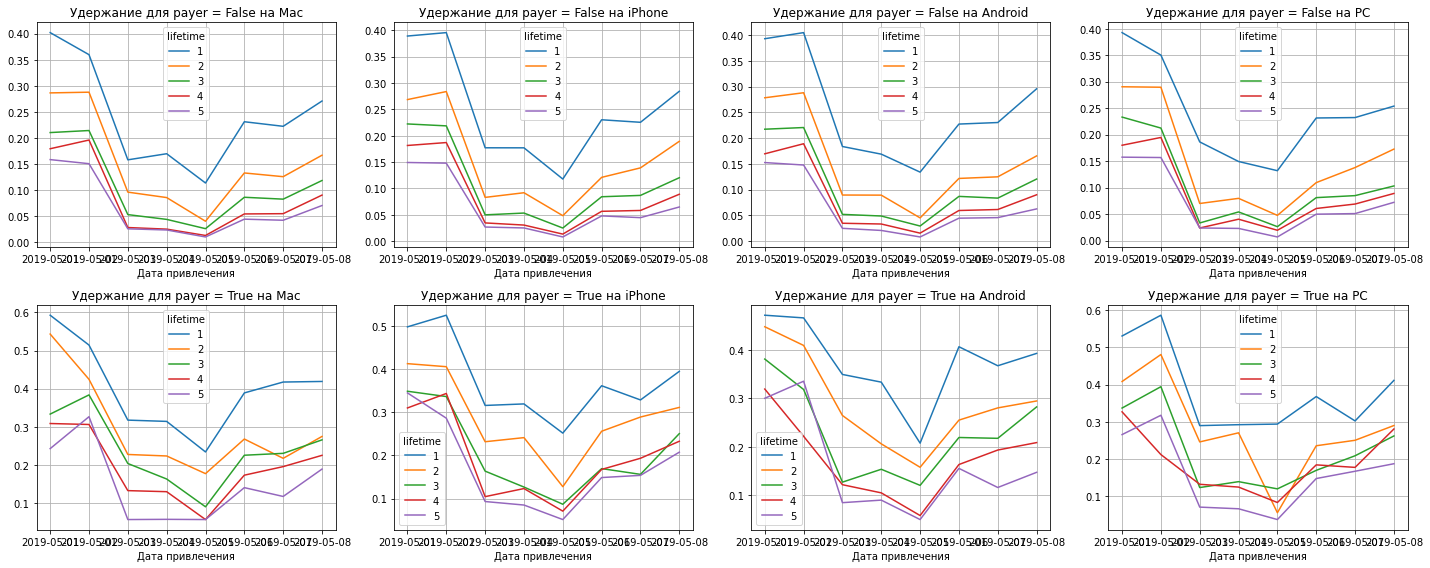

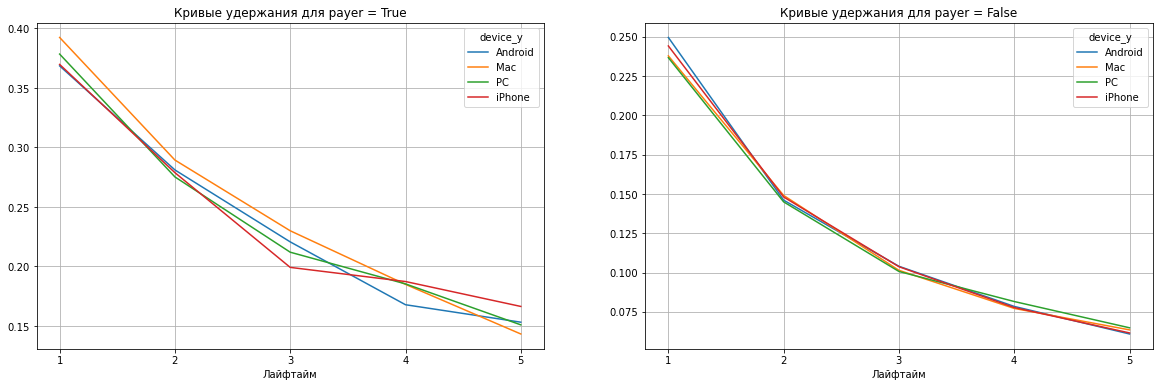

In [42]:
show_retention_plots(
    sessions,
    profiles=profiles,
    observation_date=datetime.datetime(2019, 5, 13).date(),
    horizon=6,
    dimensions=['device_y'],
)